# Experiments results 

- Experiment 1: MACHO (PT) - Ogle (FT)
- Experiment 2: MACHO (PT) - Subsets of Ogle (FT) (20 - 50 - 100 observations per class)

In [82]:
cd /tf/astromer

/tf/astromer


In [83]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to disable GPU
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import matplotlib.pyplot as plt
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator
from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

def load_weights(model, weights_path):
    model.load_weights(weights_path)
    model.trainable=False
    return model

In [85]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Experiment 1: Pretraning on MACHO - Finetuning on Ogle

In [170]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from presentation.experiments.exp_1 import get_mlp, get_lstm, get_lstm_att, init_astromer, valid_step
from sklearn.metrics import precision_recall_fscore_support
from core.data import load_records
from presentation.experiments.mlp_exp_1 import load_embeddings

In [171]:
astromer_weights = './weights/astromer_10022021/finetuning/alcock'
exp_folder = './experiments/alcock/'
data_exp = './data/records/alcock/'

In [172]:
encoder = init_astromer(astromer_weights)

In [173]:
test_obj_df = pd.read_csv(data_exp+'test_objs.csv')

classes_name = list(test_obj_df['class'].unique())
print(classes_name)
num_classes = len(classes_name)

['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc']


In [174]:
test_batches = load_records(data_exp+'/test', batch_size=128, 
                            max_obs=200,
                            msk_frac=0., rnd_frac=0., same_frac=0., 
                            repeat=1,
                            is_train=False) # repeat 1 == no repeat

test_embs = load_embeddings(os.path.join(data_exp.replace('./data/records', 
                                                              'embeddings'), 'test'),
                                num_classes, 128)

Testing mode


In [176]:
lstm     = get_lstm(256, num_classes, 200, dropout=0.5)
mlp_att  = get_mlp(exp_folder+'/mlp_att/model/')
lstm_att = get_lstm_att(256, num_classes, encoder=encoder, dropout=0.5)

OSError: SavedModel file does not exist at: ./experiments/alcock//mlp_att/model//{saved_model.pbtxt|saved_model.pb}

In [136]:
y_pred = mlp_att.predict(test_embs)
y_pred.shape

(600, 6)

In [137]:
lstm     = load_weights(lstm, exp_folder+'/lstm/weights')
lstm_att = load_weights(lstm_att, exp_folder+'/lstm_att/weights')

In [166]:
%%time
lstm_results     = {'name': 'LSTM', 'y_pred': [], 'y_true': [], 'cce': []}
mlp_att_results  = {'name': 'MLP+ATT', 'y_pred': [], 'y_true': [], 'cce': []}
lstm_att_results = {'name': 'LSTM+ATT', 'y_pred': [], 'y_true': [], 'cce': []}

for batch in test_batches:
    acc, ce, y_pred, y_true = valid_step(lstm, batch, return_pred=True)
    lstm_results['y_pred'].append(y_pred.numpy())
    lstm_results['y_true'].append(y_true.numpy())
    lstm_results['cce'].append(ce.numpy())
        
    acc, ce, y_pred, y_true = valid_step(lstm_att, batch, return_pred=True)
    lstm_att_results['y_pred'].append(y_pred.numpy())
    lstm_att_results['y_true'].append(y_true.numpy())
    lstm_att_results['cce'].append(ce.numpy())
        

mlp_att_results['y_pred'] = mlp_att.predict(test_embs)
mlp_att_results['y_true'] = np.concatenate([np.argmax(y_true, 1) for _, y_true in test_embs], 0)
mlp_att_results['cce'] = mlp_att.evaluate(test_embs)[0]

5/5 [==============================] - 0s 51ms/step - loss: 2.4306 - accuracy: 0.2500
CPU times: user 27.2 s, sys: 1.93 s, total: 29.1 s
Wall time: 6.68 s


In [167]:
def concat_batches_results(results):
    results['y_pred'] = np.concatenate(results['y_pred'], 0)
    results['y_true'] = np.concatenate(results['y_true'], 0)
    results['cce'] = np.mean(results['cce'], 0)
    return results

In [168]:
lstm_results     = concat_batches_results(lstm_results)
lstm_att_results = concat_batches_results(lstm_att_results)

In [169]:
print('{} & {} & {} & {} \\\\\hline'.format('Model', 'F1 Score', 'Recall', 'Precision'))
for result in [lstm_results, mlp_att_results, lstm_att_results]:
#     if result['name'] == 'LSTM': continue
    if result['name'] == 'MLP+ATT':
        y_pred_lab = np.argmax(result['y_pred'], 1)
    else:
        y_pred_lab = np.argmax(result['y_pred'][:, -1, :], 1)
        
    prec, recall, f1, _ = precision_recall_fscore_support(result['y_true'], 
                                                          y_pred_lab, 
                                                          average='macro')
    
    print('{} & {:.2f} & {:.2f} & {:.2f} \\\\\hline'.format(result['name'], f1, recall, prec))

Model & F1 Score & Recall & Precision \\\hline
LSTM & 0.14 & 0.25 & 0.10 \\\hline
MLP+ATT & 0.12 & 0.25 & 0.08 \\\hline
LSTM+ATT & 0.70 & 0.71 & 0.76 \\\hline


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['evaluation_loss_vs_iterations', 'evaluation_accuracy_vs_iterations', 'epoch_loss', 'epoch_accuracy'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': [], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


KeyError: 'epoch_loss'

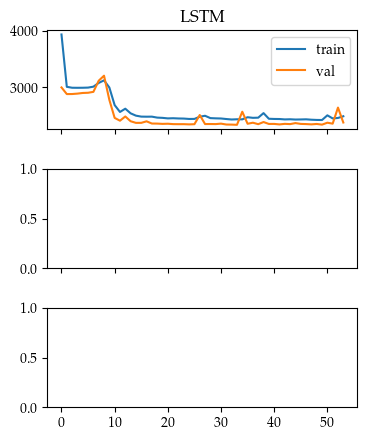

In [165]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics_2(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['scalars']}
    print(ea.Tags())
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = v.simple_value
            metrics[v.tag].append(value)
    
    
    metrics['xentropy'] = metrics.pop('epoch_loss')
    metrics['accuracy'] = metrics.pop('epoch_accuracy')
    
    return metrics

fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    if name =='mlp_att':
        val_metrics = get_metrics_2(os.path.join(
            exp_folder, name, 'logs', 'validation'))
        train_metrics = get_metrics_2(
            os.path.join(exp_folder, name, 'logs', 'train'))
    else:
        val_metrics = get_metrics(os.path.join(
            exp_folder, name, 'logs', 'valid'))
        train_metrics = get_metrics(
            os.path.join(exp_folder, name, 'logs', 'train'))
        
    axes[index].plot(train_metrics['xentropy'], label='train')
    axes[index].plot(val_metrics['xentropy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')

In [ ]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
#     if name == 'lstm':continue
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'valid'))
    axes[index].plot(train_metrics['accuracy'], label='train')
    axes[index].plot(val_metrics['accuracy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Accuracy', va='center', rotation='vertical')

In [28]:
lstm_cm     = confusion_matrix(lstm_results['y_true'], np.argmax(lstm_results['y_pred'][:, -1, :], 1), normalize='true')
mlp_att_cm  = confusion_matrix(mlp_att_results['y_true'], np.argmax(mlp_att_results['y_pred'], 1), normalize='true')
lstm_att_cm = confusion_matrix(lstm_att_results['y_true'], np.argmax(lstm_att_results['y_pred'][:, -1, :], 1), normalize='true')

In [31]:
classes_name = [x.replace('_', '\_') for x in classes_name]

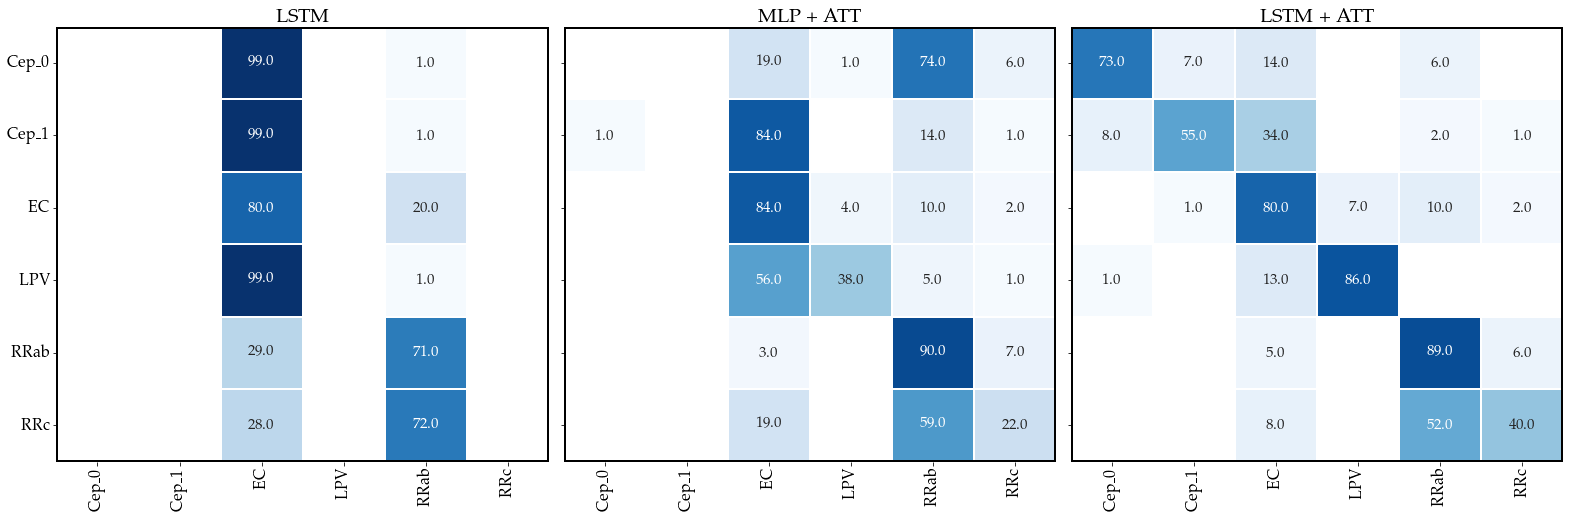

In [32]:
fig, axes = plt.subplots(1,3, figsize=(27,8), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(lstm_cm, axes[0], title='LSTM', class_names=classes_name)
axes[1] = plot_cm(mlp_att_cm, axes[1], title='MLP + ATT', class_names=classes_name)
axes[2] = plot_cm(lstm_att_cm, axes[2], title='LSTM + ATT', class_names=classes_name)